In [1]:
from skimage import io, color, filters, measure
from skimage.morphology import area_closing, area_opening, dilation
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle

In [2]:
def threshold(image, th):
    shape = np.shape(image)
    binarised = np.zeros(shape)

    if len(shape) == 3:
        image = image.mean(axis=2)  
    elif len(shape) > 3:
        raise ValueError('Bildet må være 2D eller ha tre kanaler (RGB).')
    for i, row in enumerate(image):
        for j, value in enumerate(row):
            binarised[i][j] = 0 if value >= th else 1
    return binarised

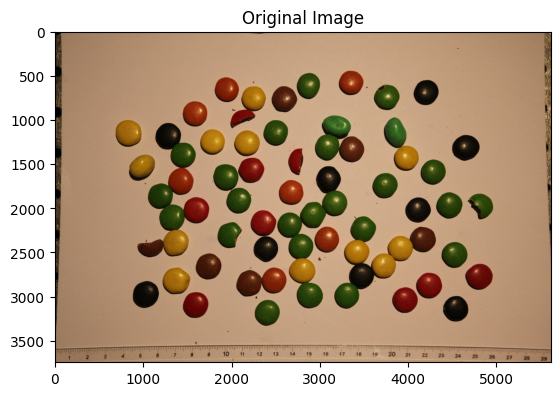

In [3]:
#viser originalbildet
ImgPath = 'IMG_2754_nonstop_alltogether.JPG'
original_image = io.imread(ImgPath)
cut_image = original_image[200:3500, 300:5500]
plt.figure()
plt.title("Original Image")
plt.imshow(original_image)

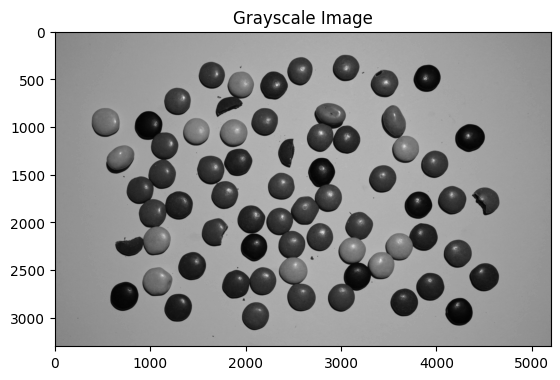

In [4]:
# Leser bildet som gråtone og beskjærer et område for å fokusere på objektene og forhindrer kantene forstryrrer
image = io.imread(ImgPath, as_gray=True)
gray_image = image[200:3500, 300:5500]
plt.figure()
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap='gray')

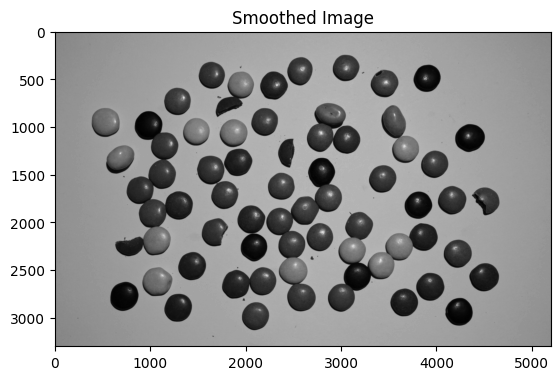

In [5]:
#Bruker Gaussisk filter for å glatte bildet og redusere høyfrekvent støy
smoothed_image = filters.gaussian(gray_image, sigma=1)
plt.figure()
plt.title("Smoothed Image") 
plt.imshow(smoothed_image, cmap='gray')

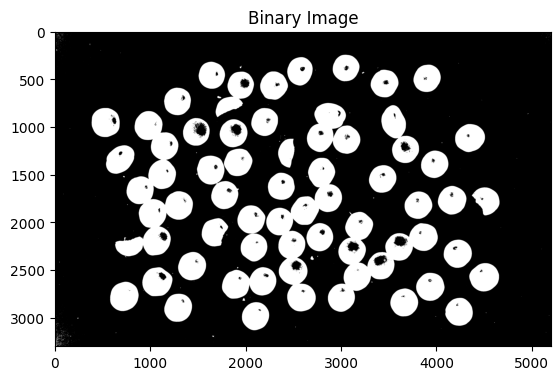

In [6]:
#bruker threshold_triangle for å finne en god terskelverdi for å binarisere bildet
triangle_threshold = filters.threshold_triangle(gray_image)
binary_image = threshold(gray_image, triangle_threshold)
plt.figure()
plt.title("Binary Image")
plt.imshow(binary_image, cmap='gray')

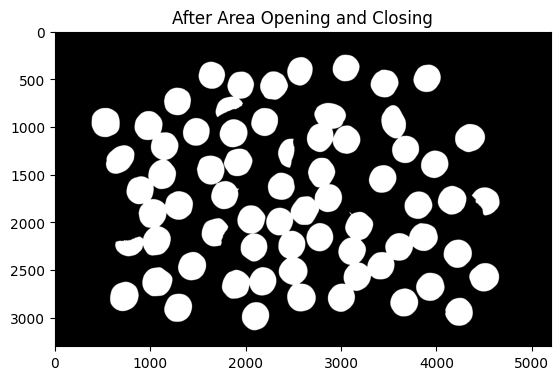

In [7]:
#bruker closing og opening for å fjerne små hull og objekter, relativit stor verdi for å fjerne litt større objekter også
closed_image = area_closing(binary_image, 13000)
final_image = area_opening(closed_image, 12000)
plt.figure()
plt.title("After Area Opening and Closing")
plt.imshow(final_image, cmap='gray')

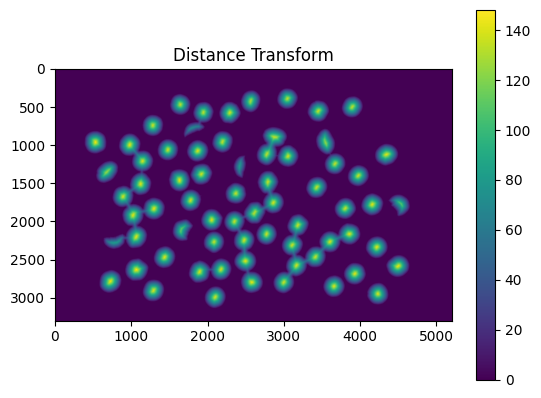

In [8]:
#finner distansen mellom objektene
distance = ndi.distance_transform_edt(final_image)
plt.figure()
plt.title("Distance Transform")
plt.imshow(distance)
plt.colorbar()

Amount of objects = 69


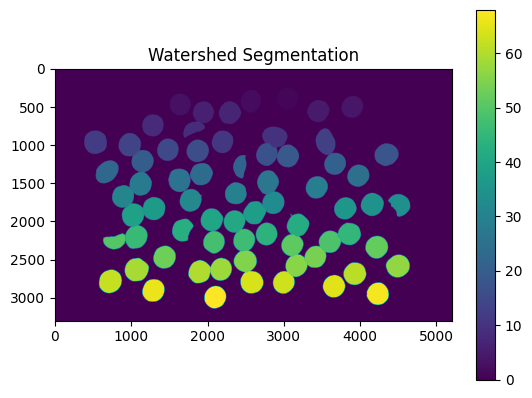

In [9]:
#bruker watershed for å segmentere objektene
l_max = peak_local_max(distance, footprint=np.ones((30, 30)), labels=final_image.astype(int), min_distance=150)
l_max_mask = np.zeros_like(distance, dtype=bool)
l_max_mask[tuple(l_max.T)] = True



#definerer markører og bruker watershed for å segmentere objektene
markers, _ = ndi.label(l_max_mask)
labels = watershed(-distance, markers, mask=final_image, watershed_line=True)
plt.figure()
plt.title("Watershed Segmentation")
plt.imshow(labels)
plt.colorbar()
print(f'Amount of objects = {len(np.unique(labels))}')

objects: 68


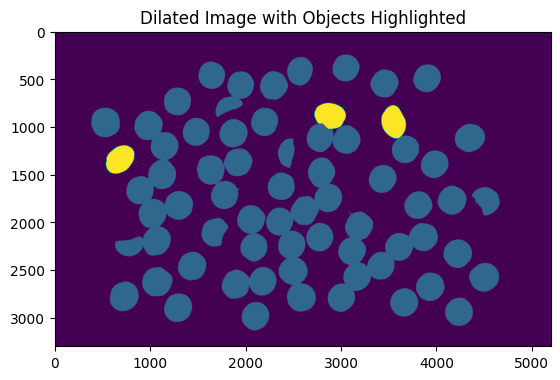

In [10]:
#finner egenskapene til objektene
props = measure.regionprops(labels)
print(f'objects: {len(props)}')

#filterer ut objekter som ikke er relevante med tanken på størrelse og form
filtered_regions = [prop for prop in props if prop.eccentricity >= 0.30 and prop.major_axis_length >= 330]
highlighted_objects = dilation(final_image, footprint=np.ones((2, 2)))
for item in filtered_regions:
    for coord in item.coords:
        highlighted_objects[coord[0], coord[1]] = 3
plt.figure()
plt.title("Dilated Image with Objects Highlighted")
plt.imshow(highlighted_objects)

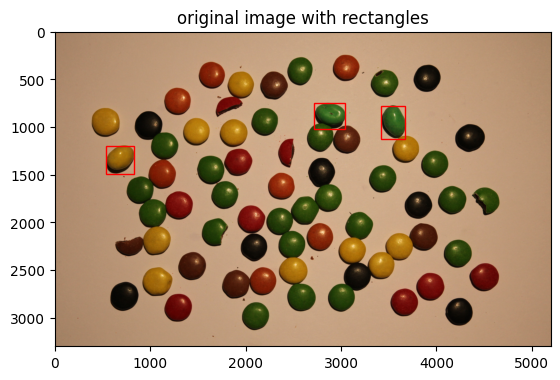

In [11]:
#visualiserer objektene med og plasserer rektangler rundt dem
rectangles = []
for item in filtered_regions:
    X_values = [coord[0] for coord in item.coords]
    Y_values = [coord[1] for coord in item.coords]
    min_x, max_x = min(X_values), max(X_values)
    min_y, max_y = min(Y_values), max(Y_values)
    rectangles.append((min_y, min_x, max_y - min_y, max_x - min_x))

plt.figure()
plt.title("original image with rectangles")
plt.imshow(cut_image)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle((rectangle[0], rectangle[1]), rectangle[2], rectangle[3], edgecolor='red', facecolor='none', lw=1))
plt.show()